In [1]:
import numpy as np
import pandas as pd
import json
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sys import path 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
current_path = os.getcwd()

systematics_path = os.path.join(current_path,'ingestion', 'systematics')
path.append(systematics_path)
from systematics import postprocess 
input_dir = os.path.join("D:", 'Uncertainty_Challenge_input_data')
train_data_file = os.path.join(input_dir, 'train', 'data', 'data.csv')
train_labels_file = os.path.join(input_dir, 'train', 'labels', "data.labels")
train_settings_file = os.path.join(input_dir, 'train', 'settings', "data.json")
train_weights_file = os.path.join(input_dir, 'train', 'weights', "data.weights")

# read train data
data = pd.read_csv(train_data_file)

# read train labels
with open(train_labels_file, "r") as f:
    labels = np.array(f.read().splitlines(), dtype=float)

# read train settings
with open(train_settings_file) as f:
    settings = json.load(f)

# read train weights
with open(train_weights_file) as f:
    weights = np.array(f.read().splitlines(), dtype=float
                       )
    


In [2]:
theta = 0.5
gamma_roi = weights[labels == 1].sum()
beta_roi = weights[labels == 0].sum()

def _sigma_asimov_CR(mu):
    return 0

def calculate_NLL( mu_scan, weight_data,use_CR=False):

    def _sigma_asimov_SR(mu):
        return mu*gamma_roi + beta_roi

    sum_data_total_SR = weight_data.sum()
    sum_data_total_CR = 0
    comb_llr = []
    for i, mu in enumerate(mu_scan):
        hist_llr = (
            -2
            * sum_data_total_SR
            * np.log((_sigma_asimov_SR(mu) / _sigma_asimov_SR(1.0)))
        ) + (2 * (_sigma_asimov_SR(mu) - _sigma_asimov_SR(1.0)))

        if use_CR:
            hist_llr_CR = (
                -2
                * sum_data_total_CR
                * np.log((_sigma_asimov_CR(mu) / _sigma_asimov_CR(1.0)))
                ) + (2 * (_sigma_asimov_CR(mu) - _sigma_asimov_CR(1.0)))
        else:
            hist_llr_CR=0
            #print("do not use CR")    
        #DR time is spent here ?        


        comb_llr.append(hist_llr + hist_llr_CR)

    comb_llr = np.array(comb_llr)
    comb_llr = comb_llr - np.amin(comb_llr)

    return comb_llr



In [3]:



# split data into train and test
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(data, labels, weights, test_size=0.2)

X_train ,X_holdout, y_train, y_holdout, w_train, w_holdout = train_test_split(X_train, y_train, w_train, test_size=0.5)


total_signal = np.sum(weights[labels == 1])
total_signal_train = np.sum(w_train[y_train == 1])
total_signal_test = np.sum(w_test[y_test == 1])
total_signal_holdout = np.sum(w_holdout[y_holdout == 1])
w_train[y_train == 1] *= total_signal / total_signal_train
w_test[y_test == 1] *= total_signal / total_signal_test
w_holdout[y_holdout == 1] *= total_signal / total_signal_holdout

total_background = np.sum(weights[labels == 0])
total_background_train = np.sum(w_train[y_train == 0])
total_background_test = np.sum(w_test[y_test == 0])
total_background_holdout = np.sum(w_holdout[y_holdout == 0])
w_train[y_train == 0] *= total_background / total_background_train
w_test[y_test == 0] *= total_background / total_background_test
w_holdout[y_holdout == 0] *= total_background / total_background_holdout


train_data = X_train.copy()
train_data['labels'] = y_train
train_data['weights'] = w_train

train_data = postprocess(train_data)

y_train = train_data.pop('labels')
w_train = train_data.pop('weights')
X_train = train_data.copy()

del train_data

holdout_data = X_holdout.copy()
holdout_data['labels'] = y_holdout
holdout_data['weights'] = w_holdout

holdout_data = postprocess(holdout_data)

y_holdout = holdout_data.pop('labels')
w_holdout = holdout_data.pop('weights')
X_holdout = holdout_data.copy()

del holdout_data




class_weights_train = (w_train[y_train == 0].sum(), w_train[y_train == 1].sum())

for i in range(len(class_weights_train)):  # loop on B then S target
    # training dataset: equalize number of background and signal
    w_train[y_train == i] *= max(class_weights_train) / class_weights_train[i]
    # test dataset : increase test weight to compensate for sampling

print("[*] --- Training Model")
X_train_sc = scaler.fit_transform(X_train)

from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, n_jobs=4)
model.fit(X_train_sc, y_train, sample_weight=w_train)

y_pred_train = model.predict_proba(X_train_sc)

from sklearn.metrics import roc_auc_score
print("[*] --- Training ROC AUC Score: ", roc_auc_score(y_train, y_pred_train[:, 1], sample_weight=w_train))



[*] --- Training Model
[*] --- Training ROC AUC Score:  0.9281545035714092


In [4]:
val_min = 1
theta_list = np.linspace(0.8, 1,500)
for theta in theta_list:

    print("theta: ", theta)

    # predict probabilities for holdout
    X_holdout_sc = scaler.transform(X_holdout)
    y_pred = model.predict_proba(X_holdout_sc)
    y_pred = y_pred[:,1]

    y_pred = (y_pred>theta).astype(int)
    gamma_roi = (w_holdout*(y_pred * y_holdout)).sum()
    beta_roi = (w_holdout*(y_pred * (1-y_holdout))).sum()

    test_data = X_test.copy()
    test_data['labels'] = y_test
    test_data['weights'] = w_test

    test_data_ps = postprocess(test_data)

    test_label = test_data_ps.pop('labels')
    test_weights = test_data_ps.pop('weights')


    X_test_sc = scaler.fit_transform(test_data_ps)

    y_pred = model.predict_proba(X_test_sc) 

    y_pred = y_pred[:,1]
    y_pred = (y_pred>theta).astype(int)

    weight = test_weights*(y_pred)

    mu_scan = np.linspace(0, 3, 100)
    hist_llr = calculate_NLL(mu_scan, weight, use_CR=False)
    hist_llr = np.array(hist_llr)

    val =  np.abs(mu_scan[np.argmin(hist_llr)] - 1)

    if val < val_min:
        val_min = val
        print("val: ", val)
        print("gamma_roi: ", gamma_roi)
        print("beta_roi: ", beta_roi)
        print("Uncertainity", np.sqrt(gamma_roi + beta_roi)/gamma_roi)
        Beta_roi = beta_roi
        Gamma_roi = gamma_roi

        best_theta = theta
        hist_llr_best = hist_llr


theta:  0.8
val:  0.3333333333333335
gamma_roi:  3204.8960112338314
beta_roi:  23812.15436389231
Uncertainity 0.051286731652558315
theta:  0.8004008016032065
val:  0.06060606060606055
gamma_roi:  3179.02719691288
beta_roi:  24691.8975910116
Uncertainity 0.05251476740724669
theta:  0.8008016032064129
theta:  0.8012024048096192
theta:  0.8016032064128257
theta:  0.8020040080160321
theta:  0.8024048096192385
theta:  0.802805611222445
theta:  0.8032064128256513
theta:  0.8036072144288577
theta:  0.8040080160320642
theta:  0.8044088176352706
theta:  0.804809619238477
theta:  0.8052104208416834
theta:  0.8056112224448898
theta:  0.8060120240480962
theta:  0.8064128256513027
theta:  0.8068136272545091
theta:  0.8072144288577154
theta:  0.8076152304609219
theta:  0.8080160320641283
theta:  0.8084168336673347
theta:  0.8088176352705412
theta:  0.8092184368737475
theta:  0.8096192384769539
theta:  0.8100200400801604
theta:  0.8104208416833668
theta:  0.8108216432865731
theta:  0.8112224448897796

C:\Users\ragan\AppData\Local\Temp\ipykernel_13320\4233195135.py:20: RuntimeWarning: invalid value encountered in scalar divide
  * np.log((_sigma_asimov_SR(mu) / _sigma_asimov_SR(1.0)))


In [5]:
print("best_theta: ", best_theta)
print("val_min: ", val_min)
print(Beta_roi)
print(Gamma_roi)
del beta_roi
del gamma_roi
beta_roi = Beta_roi
gamma_roi = Gamma_roi

best_theta:  0.901002004008016
val_min:  0.0
9664.045002384755
2532.686122259116


min NLL:  0.0
min NLL index:  33
min NLL mu:  1.0


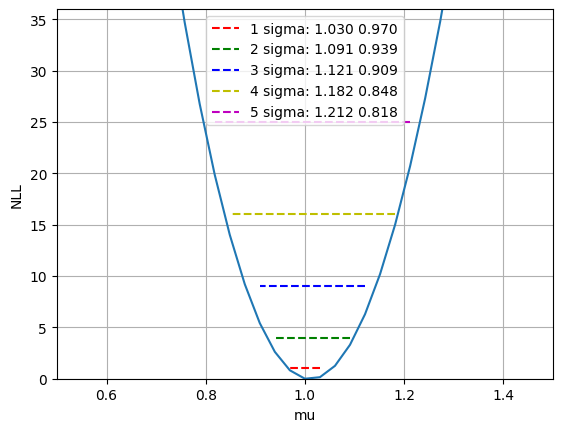

In [6]:




print("min NLL: ", min(hist_llr_best))
print("min NLL index: ", np.argmin(hist_llr_best))
print("min NLL mu: ", mu_scan[np.argmin(hist_llr_best)])


sigma_5 = (max(mu_scan[np.where((hist_llr_best <= 25) & (hist_llr_best >= 16))]), min(mu_scan[np.where((hist_llr_best < 25) & (hist_llr_best > 16))]))
sigma_4 = (max(mu_scan[np.where((hist_llr_best <= 16) & (hist_llr_best >= 9))]), min(mu_scan[np.where((hist_llr_best < 16) & (hist_llr_best > 9))]))
sigma_3 = (max(mu_scan[np.where((hist_llr_best <= 9) & (hist_llr_best >= 4))]), min(mu_scan[np.where((hist_llr_best < 9) & (hist_llr_best > 4))]))
sigma_2 = (max(mu_scan[np.where((hist_llr_best <= 4) & (hist_llr_best >= 1))]), min(mu_scan[np.where((hist_llr_best < 4) & (hist_llr_best > 1))]))
sigma_1 = (max(mu_scan[np.where((hist_llr_best <= 1) & (hist_llr_best >= 0))]), min(mu_scan[np.where((hist_llr_best < 1) & (hist_llr_best > 0))]))


plt.plot( mu_scan,hist_llr_best)
plt.hlines(1, sigma_1[0], sigma_1[1],  colors="r", linestyles="dashed", label=f"1 sigma: {sigma_1[0]:.3f} {sigma_1[1]:.3f}")
plt.hlines(4, sigma_2[0], sigma_2[1],  colors="g", linestyles="dashed", label=f"2 sigma: {sigma_2[0]:.3f} {sigma_2[1]:.3f}")
plt.hlines(9, sigma_3[0], sigma_3[1],  colors="b", linestyles="dashed", label=f"3 sigma: {sigma_3[0]:.3f} {sigma_3[1]:.3f}")
plt.hlines(16, sigma_4[0], sigma_4[1],  colors="y", linestyles="dashed", label=f"4 sigma: {sigma_4[0]:.3f} {sigma_4[1]:.3f}")
plt.hlines(25, sigma_5[0], sigma_5[1],  colors="m", linestyles="dashed", label=f"5 sigma: {sigma_5[0]:.3f} {sigma_5[1]:.3f}")


plt.legend()

plt.xlabel("mu")    
plt.ylabel("NLL")
plt.ylim(0, 36)
plt.xlim(0.5, 1.5)
plt.grid(True)
plt.show()



In [7]:
def shuffle_dataframe(df):
    # Convert DataFrame to NumPy array
    array = df.to_numpy()

    # Shuffle the array
    np.random.shuffle(array)

    # Convert the shuffled array back to a DataFrame
    shuffled_df = pd.DataFrame(array, columns=df.columns)

    return shuffled_df


signal_test:  9685.251000000015
background_test:  2860898.713599994
n:  736366
signal_test_bs:  13401
background_test_bs:  1545636
weight:  16113
mu:  2.5462906520223987
gamma_roi:  2532.686122259116
beta_roi:  9664.045002384755
signal_test:  9685.251000000015
background_test:  2860898.713599994
n:  736366
signal_test_bs:  13163
background_test_bs:  1545457
weight:  15928
mu:  2.473245674844183
gamma_roi:  2532.686122259116
beta_roi:  9664.045002384755
signal_test:  9685.251000000015
background_test:  2860898.713599994
n:  736366
signal_test_bs:  13257
background_test_bs:  1542244
weight:  16036
mu:  2.515888148007682
gamma_roi:  2532.686122259116
beta_roi:  9664.045002384755
signal_test:  9685.251000000015
background_test:  2860898.713599994
n:  736366
signal_test_bs:  13495
background_test_bs:  1545154
weight:  16149
mu:  2.560504809743565
gamma_roi:  2532.686122259116
beta_roi:  9664.045002384755
signal_test:  9685.251000000015
background_test:  2860898.713599994
n:  736366
signal_t

(0.0, 36.0)

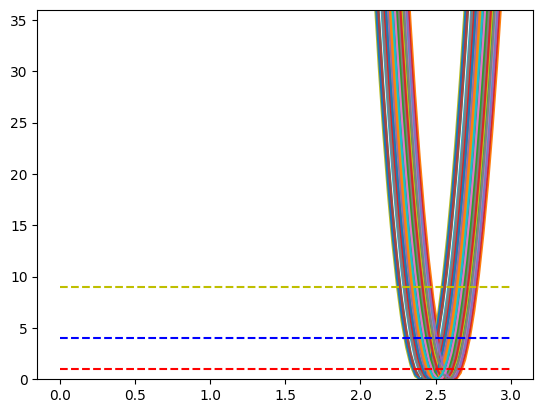

In [13]:
p16s = []
p84s = []
import bootstrap as bs


X_test_sc = scaler.fit_transform(test_data)

for i in range(100):

    signal_test = w_test[y_test == 1]
    background_test = w_test[y_test == 0]

    print("signal_test: ", signal_test.sum())
    print("background_test: ", background_test.sum())

    n = int(len(y_test))
    print("n: ", n)
    w_test_mu = w_test.copy()
    
    w_test_mu[y_test==1] = w_test[y_test==1]*2.5
    test_bs = bs.bootstrap_data(X_test, w_test_mu, y_test,seed=i)

    test_df = test_bs['data']
    test_df['label'] = test_bs['label']    
    test_df['weights'] = test_bs['weights']

    test_df_pp = postprocess(test_df)


    y_test_bs = test_df_pp.pop('label')
    w_test_bs = test_df_pp.pop('weights')

    signal_test_bs = w_test_bs[y_test_bs == 1]
    background_test_bs = w_test_bs[y_test_bs == 0]
    print("signal_test_bs: ", signal_test_bs.sum())
    print("background_test_bs: ", background_test_bs.sum())



    X_test_bs = scaler.fit_transform(test_df_pp)

    y_pred = model.predict_proba(X_test_bs)
    y_pred = y_pred[:,1]

    y_pred = (y_pred>best_theta).astype(int)


    weight = w_test_bs*(y_pred)

    print("weight: ", weight.sum())
    print("mu: ", (weight.sum() - beta_roi)/gamma_roi)
    print("gamma_roi: ", gamma_roi)
    print("beta_roi: ", beta_roi)


    mu_scan = np.linspace(0, 3, 100)
    hist_llr = calculate_NLL(mu_scan, weight, use_CR=False)
    hist_llr = np.array(hist_llr)

    if (mu_scan[np.where((hist_llr <= 1.0) & (hist_llr >= 0.0))].size == 0):
        p16 = 0
        p84 = 0
    else:
        p16 = min(mu_scan[np.where((hist_llr <= 1.0) & (hist_llr >= 0.0))])
        p84 = max(mu_scan[np.where((hist_llr <= 1.0) & (hist_llr >= 0.0))]) 

    p16s.append(p16)
    p84s.append(p84)

    plt.plot( mu_scan,hist_llr)

plt.hlines(1, 0, 3, colors="r", linestyles="dashed")
plt.hlines(4, 0, 3, colors="b", linestyles="dashed")
plt.hlines(9, 0, 3, colors="y", linestyles="dashed")
plt.ylim(0, 36)


p16s:  [2.515151515151515, 2.4242424242424243, 2.484848484848485, 2.515151515151515, 2.4242424242424243, 2.484848484848485, 2.4545454545454546, 2.515151515151515, 2.4242424242424243, 2.393939393939394, 2.484848484848485, 2.5757575757575757, 2.4545454545454546, 2.4545454545454546, 2.4242424242424243, 2.4242424242424243, 2.4545454545454546, 2.515151515151515, 2.4242424242424243, 2.3636363636363638, 2.4545454545454546, 2.4545454545454546, 2.5454545454545454, 2.484848484848485, 2.5454545454545454, 2.4242424242424243, 2.4545454545454546, 2.4242424242424243, 2.5757575757575757, 2.4545454545454546, 2.484848484848485, 2.484848484848485, 2.4242424242424243, 2.4242424242424243, 2.4545454545454546, 2.3636363636363638, 2.5454545454545454, 2.4242424242424243, 2.5454545454545454, 2.515151515151515, 2.4242424242424243, 2.4545454545454546, 2.484848484848485, 2.5757575757575757, 2.393939393939394, 2.515151515151515, 2.4242424242424243, 2.4545454545454546, 2.4242424242424243, 2.4545454545454546, 2.42424

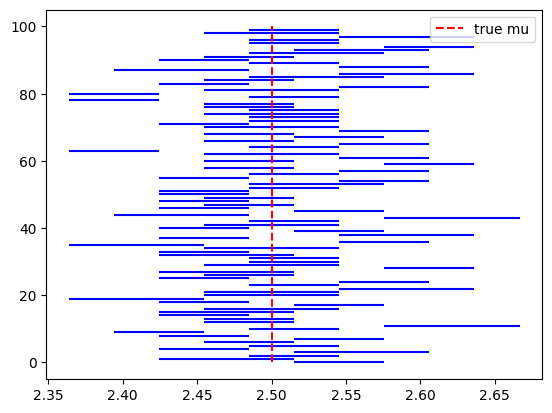

In [15]:
for i, (p16, p84) in enumerate(zip(p16s, p84s)):
    plt.hlines(y=i, xmin=p16, xmax=p84, colors='b')
plt.vlines(x=2.5, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed',label='true mu')
plt.legend()



print("p16s: ", p16s)
print("p84s: ", p84s)

In [16]:
def Quantiles_Score( mu, p16, p84, eps=1e-3):
    
    def Interval(p16, p84):
        """Compute the average of the intervals defined by vectors p16 and p84."""
        return np.mean(p84 - p16)

    def Coverage(mu, p16, p84):
        """Compute the fraction of times scalar mu is within intervals defined by vectors p16 and p84."""
        return_coverage = np.mean((mu >= p16) & (mu <= p84))
        return return_coverage

    def f(x, n_tries, max_coverage=1e4, one_sigma = 0.6827):
            sigma68 = np.sqrt(((1-one_sigma)*one_sigma*n_tries))/n_tries

            if (x >= one_sigma-2*sigma68 and x <= one_sigma+2*sigma68):
                out = 1
            elif (x < one_sigma-2*sigma68):
                out = 1 + abs((x-(one_sigma-2*sigma68))/sigma68)**4
            elif (x > one_sigma+2*sigma68):
                out = 1 + abs((x-(one_sigma+2*sigma68))/sigma68)**3
            return out


    coverage = Coverage(mu, p16, p84)
    interval = Interval(p16, p84)
    score = -np.log((interval + eps) * f(coverage, n_tries=mu.shape[0]))
    return interval, coverage, score


In [17]:
mus = np.ones(100)*2.5
p16s = np.array(p16s)
p84s = np.array(p84s)

intervel,coverage, score = Quantiles_Score(mus, p16s, p84s)

In [18]:
print("intervel: ", intervel)
print("coverage: ", coverage)
print("score: ", score)


intervel:  0.06969696969696965
coverage:  0.5
score:  -0.04150206071679593
